In [821]:
import numpy as np
import datetime as date
import pandas as pd
import scipy
import os
from scipy import integrate
from sklearn import model_selection, linear_model, neighbors, preprocessing, metrics

import matplotlib.pyplot as plt

In [2]:
lookup = pd.read_csv("../corona_data_jhucsse/COVID-19/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv")

confirmed = pd.read_csv("../corona_data_jhucsse/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
recovered = pd.read_csv("../corona_data_jhucsse/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
deaths = pd.read_csv("../corona_data_jhucsse/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")

In [418]:
data = {}
data['confirmed'] = {}
data['recovered'] = {}
data['deaths'] = {}
data['active'] = {}
data['closed'] = {}
data['susceptible'] = {}
data['population'] = {}

data['selected'] = {}
data['dates'] = {}
data['datenums'] = {}

[5.94921497 0.05541349 0.01079377 0.33059216]
[[ 2.60444023e-01  5.48622453e-04 -7.03552897e-05 -1.10415871e-03]
 [ 5.48622453e-04  1.17100679e-06 -1.94398026e-07 -3.05089034e-06]
 [-7.03552897e-05 -1.94398026e-07  4.78310642e-07  7.50662618e-06]
 [-1.10415871e-03 -3.05089034e-06  7.50662618e-06  2.17888599e-03]]


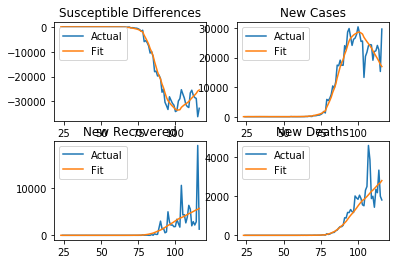

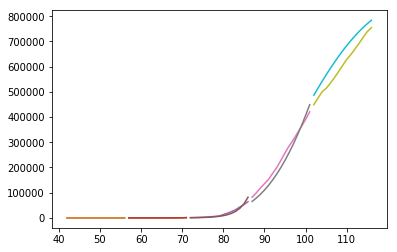

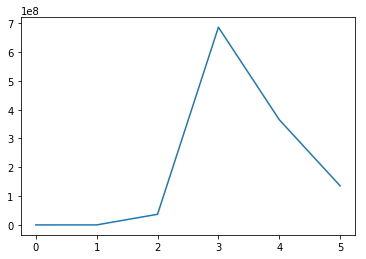

In [1191]:
country = 'US'

data['confirmed'][country]   = confirmed[confirmed['Country/Region']==country].iloc[:,4:].sum(axis=0)
data['recovered'][country]   = recovered[recovered['Country/Region']==country].iloc[:,4:].sum(axis=0)
data['deaths'][country]      = deaths[deaths['Country/Region']==country].iloc[:,4:].sum(axis=0)

data['selected'][country]    = data['confirmed'][country] > 0

data['confirmed'][country]   = data['confirmed'][country][data['selected'][country]]
data['recovered'][country]   = data['recovered'][country][data['selected'][country]]
data['deaths'][country]      = data['deaths'][country][data['selected'][country]]

data['closed'][country]      = data['deaths'][country] + data['recovered'][country]

data['population'][country]  = lookup[lookup['Country_Region'] == country]['Population'].values[0]

data['active'][country]      = data['confirmed'][country] - data['recovered'][country] - data['deaths'][country]
data['susceptible'][country] = data['population'][country] - data['confirmed'][country]

data['dates'][country]       = data['confirmed'][country].index
data['datenums'][country]    = [pd.Period(date).dayofyear for date in data['dates'][country]]

inputs = 4

def beta(t,beta0,kappa):
    return beta0 * np.exp(0.0-kappa*(t-data['datenums'][country][0]))

pinit = [1.5,0.05,0.5,0.3]

def sir_nonlinear_model(x,beta0,kappa,mu,p):
    t = x[:,0]
    s = x[:,1]
    i = x[:,2]
    r = x[:,3]
    d = x[:,4]
    rho = 0
    ds = -beta(t,beta0,kappa)*s*i/data['population'][country]+rho*r
    di = beta(t,beta0,kappa)*s*i/data['population'][country]-mu*i
    dr = mu*(1.0-p)*i-rho*r
    dd = mu*p*i
    return np.array(np.concatenate((ds,di,dr,dd)),dtype=float)

def sir_nonlinear_model2(x,t,beta0,kappa,mu,p):
    s = x[0]
    i = x[1]
    r = x[2]
    d = x[3]
    rho = 0
    ds = -beta(t,beta0,kappa)*s*i/data['population'][country]+rho*r
    di = beta(t,beta0,kappa)*s*i/data['population'][country]-mu*i
    dr = mu*(1.0-p)*i-rho*r
    dd = mu*p*i
    return np.array([ds,di,dr,dd],dtype=float)

xdata = np.array(np.vstack((data['datenums'][country][1:],data['susceptible'][country][1:],data['active'][country][1:],data['recovered'][country][1:],data['deaths'][country][1:])).T,dtype=float)
ally = np.array(np.vstack((data['susceptible'][country][1:],data['active'][country][1:],data['recovered'][country][1:],data['deaths'][country][1:])).T,dtype=float)
ydata = np.array(np.vstack((data['susceptible'][country].diff()[1:],data['active'][country].diff()[1:],data['recovered'][country].diff()[1:],data['deaths'][country].diff()[1:])).T,dtype=float)

params, pcov = scipy.optimize.curve_fit(sir_nonlinear_model,xdata,ydata.T.flatten(),pinit)
print(params)
print(pcov)

plt.figure(2)
fitmodel = sir_nonlinear_model(xdata,*params)
plt.subplot(221)
plt.title('Susceptible Differences')
plt.plot(data['datenums'][country][1:],data['susceptible'][country][1:].diff())
plt.plot(data['datenums'][country][1:],fitmodel[:len(xdata)])
plt.legend(['Actual','Fit'])

plt.subplot(222)
plt.title('New Cases')
plt.plot(data['datenums'][country][1:],data['active'][country][1:].diff())
plt.plot(data['datenums'][country][1:],fitmodel[len(xdata):2*len(xdata)])
plt.legend(['Actual','Fit'])

plt.subplot(223)
plt.title('New Recovered')
plt.plot(data['datenums'][country][1:],data['recovered'][country][1:].diff())
plt.plot(data['datenums'][country][1:],fitmodel[2*len(xdata):3*len(xdata)])
plt.legend(['Actual','Fit'])

plt.subplot(224)
plt.title('New Deaths')
plt.plot(data['datenums'][country][1:],data['deaths'][country][1:].diff())
plt.plot(data['datenums'][country][1:],fitmodel[3*len(xdata):4*len(xdata)])
plt.legend(['Actual','Fit'])

daysbefore = 10
y0 = xdata[-daysbefore][1:]
tbefore = data['datenums'][country][-daysbefore:1:-1]
ymodel = scipy.integrate.odeint(sir_nonlinear_model2,y0,tbefore,args=tuple(params))[::-1]
t0 = data['datenums'][country][-daysbefore]
tmax = 150
textend = np.array(range(t0,tmax))
n = 1000
y0 = xdata[-daysbefore][1:]
ypredict = np.zeros((inputs,n,len(textend)))
for i in range(n):
    newparams = np.random.multivariate_normal(params,pcov)
    yp = scipy.integrate.odeint(sir_nonlinear_model2,y0,textend,args=tuple(newparams))
    for j in range(inputs):
        ypredict[j,i] = yp[:,j]
    
ypm = np.zeros((inputs,3,len(textend)))
for j in range(inputs):
    ypm[j,0] = pd.DataFrame(ypredict[j,:]).mean(axis=0)
    ypm[j,1] = ypm[j,0] + 2.0*pd.DataFrame(ypredict[j,:]).std(axis=0)
    ypm[j,2] = ypm[j,0] - 2.0*pd.DataFrame(ypredict[j,:]).std(axis=0)

err = []
tcsv = model_selection.TimeSeriesSplit(n_splits = 5)
t = 0
plt.figure(0)
for train, test in tcsv.split(xdatav):
    xtrain,xtest,ytrain,ytest = xdata[train],xdata[test],ydata[train],ydata[test]
    
    params, pcov = scipy.optimize.curve_fit(sir_nonlinear_model,xtrain,ytrain.T.flatten(),pinit)
    
    y0 = xtest[-1][1:]
    ymodelval = scipy.integrate.odeint(sir_nonlinear_model2,y0,xtest[::-1,0],args=tuple(params))[::-1]
    
    err.append(metrics.mean_squared_error(ymodelval.T.flatten(),ally[test].T.flatten()))
    
    plt.plot(xtest[:,0],data['active'][country][test])
    plt.plot(xtest[:,0],ymodelval[:,1])
    t = t + 1
plt.figure(1)
err.append(metrics.mean_squared_error(ymodel.T.flatten(),ally[:-daysbefore].T.flatten()))
plt.plot(err)

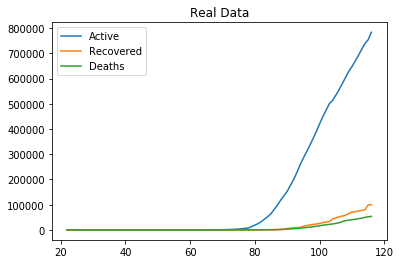

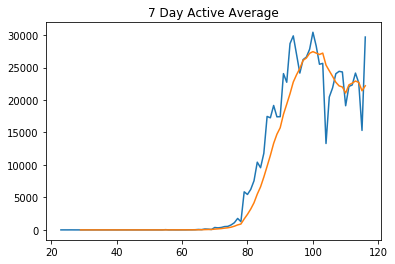

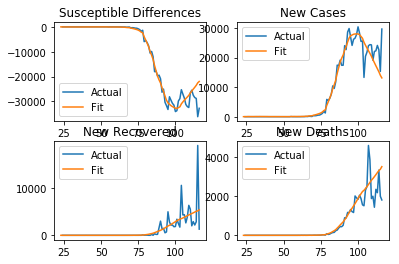

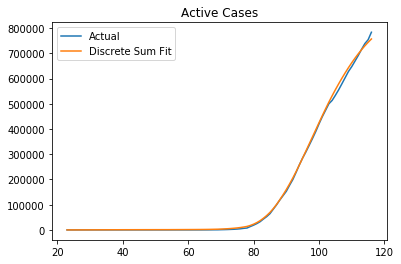

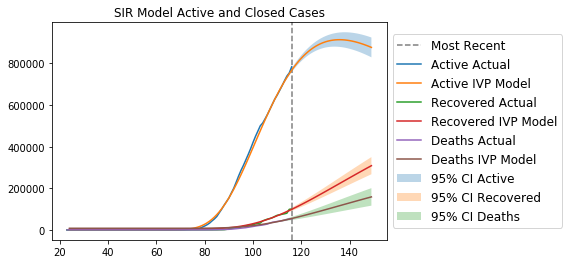

In [1192]:
plt.figure(0)
plt.title('Real Data')
plt.plot(data['datenums'][country],data['active'][country])
plt.plot(data['datenums'][country],data['recovered'][country])
plt.plot(data['datenums'][country],data['deaths'][country])
plt.legend(['Active','Recovered','Deaths'])

plt.figure(1)
plt.plot(data['datenums'][country],data['active'][country].diff())
plt.plot(data['datenums'][country],data['active'][country].diff().rolling(7).mean())
plt.title('7 Day Active Average')

plt.figure(2)
fitmodel = sir_nonlinear_model(xdata,*params)
plt.subplot(221)
plt.title('Susceptible Differences')
plt.plot(data['datenums'][country][1:],data['susceptible'][country][1:].diff())
plt.plot(data['datenums'][country][1:],fitmodel[:len(xdata)])
plt.legend(['Actual','Fit'])

plt.subplot(222)
plt.title('New Cases')
plt.plot(data['datenums'][country][1:],data['active'][country][1:].diff())
plt.plot(data['datenums'][country][1:],fitmodel[len(xdata):2*len(xdata)])
plt.legend(['Actual','Fit'])

plt.subplot(223)
plt.title('New Recovered')
plt.plot(data['datenums'][country][1:],data['recovered'][country][1:].diff())
plt.plot(data['datenums'][country][1:],fitmodel[2*len(xdata):3*len(xdata)])
plt.legend(['Actual','Fit'])

plt.subplot(224)
plt.title('New Deaths')
plt.plot(data['datenums'][country][1:],data['deaths'][country][1:].diff())
plt.plot(data['datenums'][country][1:],fitmodel[3*len(xdata):4*len(xdata)])
plt.legend(['Actual','Fit'])

plt.figure(3)
plt.title('Active Cases')
plt.plot(data['datenums'][country][1:],data['active'][country][1:])
plt.plot(data['datenums'][country][1:],pd.DataFrame(fitmodel[len(xdata):2*len(xdata)]).cumsum())
plt.legend(['Actual','Discrete Sum Fit'])

plt.figure(4)
plt.title('SIR Model Active and Closed Cases')
plt.axvline(x=data['datenums'][country][-1],color='gray',linestyle='--')
for j in range(1,inputs):
    plt.plot(data['datenums'][country][1:],xdata[:,j+1])
    plt.plot(np.append(tbefore[::-1],textend),np.append(ymodel[:,j],ypm[j,0]))
for j in range(1,inputs):
    plt.fill_between(textend,ypm[j,1],ypm[j,2],alpha=0.3)
plt.legend(['Most Recent','Active Actual','Active IVP Model','Recovered Actual','Recovered IVP Model','Deaths Actual','Deaths IVP Model','95% CI Active','95% CI Recovered','95% CI Deaths'],fontsize='large',loc='center left',bbox_to_anchor=(1,0.5))

In [1189]:
data['datenums'][country][0]

22